# Blackjack

The game starts with the dealer having one face up and one face down card, while the player has two face up cards. All cards are drawn from an infinite deck (i.e. with replacement). The card values are:

- Face cards (Jack, Queen, King) have a point value of 10
- Aces can either count as 11 (called a "usable ace") or 1
- Numerical cards (2-9) have a value equal to their number

The player has the sum of cards held. The player can request additional cards (hit) until they decide to stop (stick) or exceed 21 (bust, immediate loss). After the player sticks, the dealer reveals their facedown card, and draws cards until their sum is 17 or greater. If the dealer goes bust, the player wins. If neither the player nor the dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.

There is two possible actions:

- 0: Stick
- 1: Hit

The observation consists of a 3-tuple containing: the player’s current sum, the value of the dealer’s one showing card (1-10 where 1 is ace), and whether the player holds a usable ace (0 or 1).

The player receives positive +1 rewards for winning the game, negative -1 for loosing the game and 0 reward in case of drawn.

1 - Import the 'Blackjack-v1' grid word from Gymnasium:

In [1]:
# You can get the environment from Gymnasium in the same way we got 'Frozen Lake’; 
# in order to visually plot the environment you can import it 
# using render_mode="rgb_array"

import gymnasium as gym;
blackjack = gym.make('Blackjack-v1', render_mode="rgb_array");

2 - Create a random policy as a baseline:

In [2]:
# You have to create a function that get in input a state and provide a random 
# action (in the range [0;1])

import numpy as np

def pi_random(s):
    return np.random.choice([0,1]);

3 - Show the policy in action by rendering the environment several times after different decisions from the random policy:

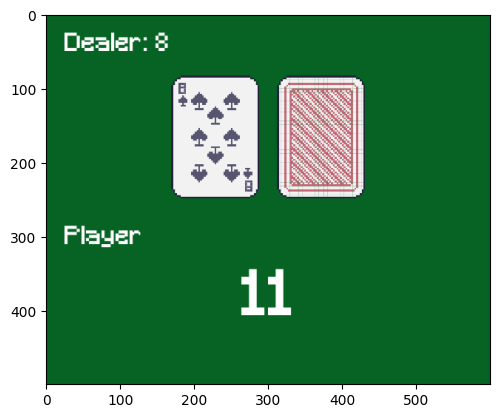

You lose!


In [3]:
# Reuse the show_policy function we implment for the lab on DP:

import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

def show_policy(env, pi, n_episodes=1):
    for _ in range(n_episodes):
        state, info = env.reset()
        done = False;
        while not done:
            action = pi(state);
            state, reward, terminated, truncated, info = env.step(action);
            if(terminated or truncated): done = True;
            clear_output(wait=True);
            plt.imshow(env.render());
            plt.show();    
    if(reward == 1): print('You win!');
    elif(reward == -1): print('You lose!');
    else: print('Draw!');            

show_policy(blackjack, pi_random);

4 - Write a brute-force function in order to evaluate the probability of success and the average return obtained by a policy, the evaluate the random policy:

In [4]:
# You can reuse the "evaluate" function we implment for the lab on DP, 
# however pay attention on how to calculte the success rate, you need to  
# consider that the agent reaches the goal if it obtains a reward of 1 at   
# the end of an episode.

def evaluate(env, pi, n_episodes=10000):
    success = 0;
    returns = []
    for _ in range(n_episodes):
        done = False;
        steps = 0;
        state, info = env.reset();
        returns.append(0.0)
        while not done:
            state, reward, terminated, truncated, info = env.step(pi(state))
            if(terminated or truncated):
                done = True;
            returns[-1] += reward;
            steps += 1;
        if terminated and reward == 1:
            success += 1;
    return (success/n_episodes)*100, np.mean(returns);

probability_success, mean_return = evaluate(blackjack, pi_random);

print("Reaches goal ", probability_success, "%");
print("Obtains an average undiscounted return of ", mean_return);

Reaches goal  28.439999999999998 %
Obtains an average undiscounted return of  -0.3909


5 - Notice that the state space is not a single integer, but a tuple of discrete states. In order to use the state as an index in the value function, you need to convert the tuple of states into a single value.

In [5]:
# To convert the tuple of discrete states 
# (Discrete(32), Discrete(11), Discrete(2)) into a single index, 
# you can treat the tuple as a coordinate in a 3D grid and 
# compute a unique index for each combination of values. 
# This is essentially flattening the multi-dimensional space 
# into a one-dimensional array. 
# Given a tuple of states (s1, s2, s3) where:
# - s1 is in the range 0 to 31 (32 possible values),
# - s2 is in the range 0 to 10 (11 possible values),
# - s3 is in the range 0 to 1 (2 possible values),
# You can calculate the index by assuming that s3 is the least 
# significant and s1 is the most significant:

# index = s1 * (11 * 2) + s2 * 2 + s3

def state_to_index(s1, s2, s3):
    index = s1 * (11 * 2) + s2 * 2 + s3
    return index

6 - Use Double Q-learning to calculate the optimal policy and the optimal state-value function:

In [36]:
# You can reuse the function we apply to the Slippery Walk environment, in particular
# select_action() to use an epsilon greedy exploration strategy, decay_schedule() to
# calculare learning rate and epsilon values and double_q_learning() to implement the
# algorithm. However, you need to use the state_to_index() function to convert the 
# state into an index.

In [6]:
def select_action(state, q, epsilon=0.1):

    # if the random number is greater than epsilon, 
    if np.random.uniform() > epsilon:
        # pick the action with the highest Q value
        action = np.argmax(q[state]);
    else:
        # otherwise, pick a random action
        action = np.random.randint(len(q[0]));

    return action;

In [7]:
def decay_schedule(init_value, min_value, decay_steps, max_steps):

    # calculate the number of the remaining steps after the decay
    rem_steps = max_steps - decay_steps;

    # logspace returns numbers spaced evenly on a log scale
    # base^start is the starting value of the sequence,
    # base^stop is the final value of the sequence
    # num is the number of values to generate
    # base is the base of the log space
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10);

    # because the values may not end exactly at 0, given it’s the log, 
    # we change them to be between 0 and 1 so that the curve looks smooth and nice.
    values = (values - values.min()) / (values.max() - values.min());

    # linear transformation and get points between init_value and min_value
    values = (init_value - min_value) * values + min_value;

    # repeats the rightmost value rem_step number of times
    values = np.pad(values, (0, rem_steps), 'edge');

    return values;

In [9]:
def double_q_learning(env, gamma=0.99, 
                      init_alpha=0.5, min_alpha=0.01, 
                      init_epsilon=1.0, min_epsilon=0.1, 
                      decay_episodes=2000, n_episodes=3000):

    # calculate the observation space size
    n_states = state_to_index(env.observation_space[0].n, env.observation_space[1].n, int(env.observation_space[2].n));

    # calculate the learning rate schedule for all episodes    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);

    # calculate epsilon for all episodes   
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes);

    # initialize the two action-value functions
    q1 = np.zeros((n_states, env.action_space.n), dtype=float);
    q2 = np.zeros((n_states, env.action_space.n), dtype=float);
    
    # the episode loop    
    for e in range(n_episodes):

        # we start episode by resetting the environment and the done flag
        state, done = env.reset(), False;
        state = state_to_index(state[0][0], state[0][1], int(state[0][2]));

         # repeat until we hit a terminal state
        while not done:
            
            # we use the mean of our two action-value functions to select action 
            action = select_action(state, (q1 + q2)/2., epsilons[e]);

            # step the environment using that action
            next_state, reward, terminated, truncated, info = env.step(action);
            next_state = state_to_index(next_state[0], next_state[1], int(next_state[2]));
            if(terminated or truncated):
                done = True;
            
            # flip a coin to determine an update to q1 or q2
            if np.random.randint(2):

                # use the action q1 thinks is best...
                argmax_q1 = np.argmax(q1[next_state]);
                
                # ...but get the value from q2 to calculate the target
                dq_learning_target = reward + gamma * q2[next_state][argmax_q1];

                # calculate the error 
                dq_learning_error = dq_learning_target - q1[state][action];
                
                # update q1
                q1[state][action] = q1[state][action] + alphas[e] * dq_learning_error;

            else:
                
                # use the action q2 thinks is best...
                argmax_q2 = np.argmax(q2[next_state]);
                
                # ...but get the value from q1 to calculate the target
                dq_learning_target = reward + gamma * q1[next_state][argmax_q2];
                dq_learning_error = dq_learning_target - q2[state][action];
                
                # update q2
                q2[state][action] = q2[state][action] + alphas[e] * dq_learning_error;
            
            # update state
            state = next_state;
        
        # extract the value functions
        q = (q1 + q2)/2.;
        v = np.max(q, axis=1);

        # and the greedy policy
        def pi(s):
            return np.argmax(q[state_to_index(s[0], s[1], int(s[2]))]);
            
    return q, v, pi;

In [10]:
q, v, pi = double_q_learning(blackjack);

7 - Calculate the performance of the obtained optimal policy using the brute force approach:

In [11]:
# You can reuse the "evaluation" function written before, 
# in order to evaluate the optimal policy

probability_success, mean_return = evaluate(blackjack, pi);
print("Reaches goal ", probability_success, "%");
print("Obtains an average undiscounted return of ", mean_return);

Reaches goal  40.79 %
Obtains an average undiscounted return of  -0.1099


8  - Show the optimal policy:

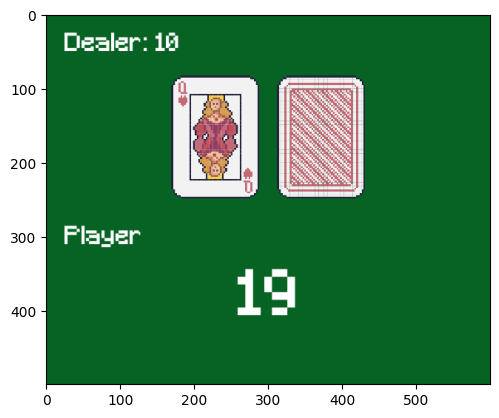

You lose!


In [12]:
# You can reuse the "show_policy" function written before, 
# in order to show the optimal policy

show_policy(blackjack, pi, n_episodes=3)